In [1]:
import pandas as pd
import numpy as np


In [2]:
# func 모음

# 1. 종목코드를 6자리로 통일. ex) 990 -> 000990
def padding(x):
    x = str(x)
    return x.rjust(6, "0")

# 2. 결산월 12월인 것만 선택
# : 전체 데이터 4963개 중에서 12월 결산인 데이터가 4836개이다. 나머지 결산월의 데이터가 전체의 2.5%로 데이터량이 작기도하고 결측치가 많아 제거
def func_yearin(x):
    if x[5:7] == '12':
        return True
    else:
        return False

# 3. 회계년도컬럼, 년도만 뽑아서 int화
def change_year(x):
    return int(x[:4])

# 4. 연결, 개별재무제표 통합을 위해 연결재무 데이터 컬럼명 통일화 : "(IFRS연결)"제거
def func_replace_col1(x):
    x = x.replace(" ","")
    x = x.replace(",","")
    x = x.replace("(비교)","")
    x = x.replace("(IFRS)","")
    x = x.replace("(*)","")
    x = x.replace("[제조]","")
    return x.replace("(IFRS연결)","")

# 5. 연결, 개별재무제표 통합을 위해 개별재무 데이터 컬럼명 통일화 : "(IFRS)"제거
def func_replace_col2(x):
    x = x.replace(" ","")
    x = x.replace(",","")
    x = x.replace("(비교)","")
    x = x.replace("(IFRS)","")
    x = x.replace("(*)","")
    x = x.replace("[제조]","")
    return x.replace("(IFRS)","")

# 6. 2020년 raw data 제외
def func_rm_2020(x):
    if x[:4] == "2020":
        return False
    else:
        return True

# 7. True, False 반전
def func_not(x):
    return not x

In [3]:
배당_df = pd.read_csv('./datasets/raw/연결개별현금배당금.csv',encoding='cp949')
배당_df

,회사명,거래소코드,회계년도,배당금_현금
0,(주)CMG제약,58820,2011/12,NaN
1,(주)CMG제약,58820,2012/12,NaN
2,(주)CMG제약,58820,2013/12,NaN
3,(주)CMG제약,58820,2014/12,NaN
4,(주)CMG제약,58820,2015/12,NaN
...,...,...,...,...
22151,흥아해운(주),3280,2016/12,632567.0
22152,흥아해운(주),3280,2017/12,NaN
22153,흥아해운(주),3280,2018/12,NaN
22154,흥아해운(주),3280,2019/12,NaN


In [4]:
배당_df["거래소코드"] = 배당_df["거래소코드"].map(padding) # 거래소코드 padding
배당_df["회계년도"] = 배당_df["회계년도"].map(change_year) # 년도만 표시
배당_df

,회사명,거래소코드,회계년도,배당금_현금
0,(주)CMG제약,058820,2011,NaN
1,(주)CMG제약,058820,2012,NaN
2,(주)CMG제약,058820,2013,NaN
3,(주)CMG제약,058820,2014,NaN
4,(주)CMG제약,058820,2015,NaN
...,...,...,...,...
22151,흥아해운(주),003280,2016,632567.0
22152,흥아해운(주),003280,2017,NaN
22153,흥아해운(주),003280,2018,NaN
22154,흥아해운(주),003280,2019,NaN


In [5]:
배당_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22156 entries, 0 to 22155
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   회사명     22156 non-null  object 
 1   거래소코드   22156 non-null  object 
 2   회계년도    22156 non-null  int64  
 3   배당금_현금  12168 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 692.5+ KB


In [6]:
배당_df.isna().sum()

회사명          0
거래소코드        0
회계년도         0
배당금_현금    9988
dtype: int64

In [7]:
배당_df.fillna(0,inplace=True)

In [8]:
## 1년에 배당을 여러번 하는 기업이 존재 
## 1년에 한 배당금을 더해준다

배당_df = 배당_df.groupby(['회사명','회계년도','거래소코드'])[['배당금_현금']].sum().reset_index()


In [9]:
# 외국계 기업 제거
def func_isnt_fcompany(x):
    if x[:1] == '9':
        return False
    else:
        return True

배당_df = 배당_df[배당_df["거래소코드"].map(func_isnt_fcompany)]

In [10]:
## 회사수와 거래소코드수 차이가나는것 확인
print("회사수 : ", len(배당_df["회사명"].unique()))
print("거래소코드수 : ", len(배당_df["거래소코드"].unique()))

회사수 :  2487
거래소코드수 :  2515


In [11]:
# 중복 거래소코드 제거
def func_overlap_code(x):
    if x == (배당_df[배당_df["회사명"]==company_name]["거래소코드"].iloc[-1]) :
        return True
    else:
        return False

list_companyname = list(배당_df["회사명"].unique())


dfs = list()


for i in list_companyname:
    company_name = i
    #각 기업별로 데이터프레임 생성
    df_concat = 배당_df[배당_df["회사명"]==i]
    df_concat = df_concat[df_concat["거래소코드"].map(func_overlap_code)] # 거래소코드 바뀌기 전의 거래소코드의 데이터는 삭제
    dfs.append(df_concat)
배당_df = pd.concat(dfs)
배당_df.reset_index(drop=True, inplace=True)

In [12]:
# 회사명이 2개인 거래소코드 존재 확인 - 엄슴
list_overlap_code = list()
for i in list(배당_df["거래소코드"].unique()):
    if len(배당_df[배당_df["거래소코드"]==i]["회사명"].unique()) > 1:
        list_overlap_code.append(i)
list_overlap_code

['036420']

In [13]:
# 기업명 변경
배당_df[배당_df['거래소코드']=='036420']
배당_df.loc[배당_df['회사명']=='(주)제이콘텐트리',['회사명']] = '(주)콘텐트리중앙'

In [14]:
배당_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20642 entries, 0 to 20641
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   회사명     20642 non-null  object 
 1   회계년도    20642 non-null  int64  
 2   거래소코드   20642 non-null  object 
 3   배당금_현금  20642 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 645.2+ KB


In [15]:
배당_df

,회사명,회계년도,거래소코드,배당금_현금
0,(주)CMG제약,2011,058820,0.0
1,(주)CMG제약,2012,058820,0.0
2,(주)CMG제약,2013,058820,0.0
3,(주)CMG제약,2014,058820,0.0
4,(주)CMG제약,2015,058820,0.0
...,...,...,...,...
20637,흥아해운(주),2016,003280,632567.0
20638,흥아해운(주),2017,003280,0.0
20639,흥아해운(주),2018,003280,0.0
20640,흥아해운(주),2019,003280,0.0


In [16]:
## 배당을 한번도 안한 기업 제거
test = 배당_df.groupby('회사명')[['배당금_현금']].sum()
badang=test[test["배당금_현금"] != 0].index
배당_df= 배당_df[배당_df["회사명"].isin(badang)].reset_index(drop=True)


In [17]:
배당_df

,회사명,회계년도,거래소코드,배당금_현금
0,(주)DB하이텍,2011,000990,0.0
1,(주)DB하이텍,2012,000990,0.0
2,(주)DB하이텍,2013,000990,0.0
3,(주)DB하이텍,2014,000990,0.0
4,(주)DB하이텍,2015,000990,0.0
...,...,...,...,...
14777,흥아해운(주),2016,003280,632567.0
14778,흥아해운(주),2017,003280,0.0
14779,흥아해운(주),2018,003280,0.0
14780,흥아해운(주),2019,003280,0.0


In [18]:
# 배당금 /당기순이익 *100 = 배당성향
df = pd.read_csv('./datasets/전처리 후/최종.csv')
print(df.columns)
당기순이익_df = df[['회사명','거래소코드','회계년도','당기순이익(손실)']]

def padding(x):
    x = str(x)
    return x.rjust(6, "0")

당기순이익_df["거래소코드"] = 당기순이익_df["거래소코드"].map(padding) # 년도만 표시

Index(['Unnamed: 0', '회사명', '거래소코드', '회계년도', '대주주지분변화분', '외국인지분분변화', '상장일',
       '자산', '당기순이익(손실)', '미처분이익잉여금(결손금)', '총자본증가율', '비유동자산증가율', '유동자산증가율',
       '자기자본증가율', '매출액증가율', '정상영업이익증가율', '순이익증가율', '총포괄이익증가율', '매출액순이익률',
       '총자본순이익률', '자기자본순이익률', '매출원가대매출액비율', '광고선전비대매출액비율', '유보율', '비유동비율',
       '유동비율', '당좌비율', '현금비율', '부채비율', '유동부채비율', '차입금비율', '이자보상배율(이자비용)',
       '유보액대비율', '유보액대납입자본배율', '투자집중도', '통계청 한국표준산업분류 10차(대분류)', '직급명',
       '1인평균지급액(임원)', '1인년간평균급여(직원)', '토빈Q', 'target', 'WW지수', 'RDS', '수명주기'],
      dtype='object')


C:\Users\msi\AppData\Local\Temp\ipykernel_3248\825431669.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  당기순이익_df["거래소코드"] = 당기순이익_df["거래소코드"].map(padding) # 년도만 표시


In [19]:
배당성향_df = pd.merge(당기순이익_df,배당_df,on=['회사명','거래소코드','회계년도'],how='inner')

In [21]:
배당성향_df['배당성향'] = 배당성향_df['배당금_현금'] / 배당성향_df['당기순이익(손실)']
배당성향_df['배당성향'] = 배당성향_df['배당성향']*100

In [22]:
배당성향_df[배당성향_df['배당성향']==-0].head(10)
배당성향_df.replace(-0,0,inplace=True)
배당성향_df[배당성향_df['배당성향']==0]

,회사명,거래소코드,회계년도,당기순이익(손실),배당금_현금,배당성향
0,(주)DB하이텍,000990,2011,-93084414.0,0.0,0.0
1,(주)DB하이텍,000990,2012,-32121504.0,0.0,0.0
2,(주)DB하이텍,000990,2013,-73243309.0,0.0,0.0
3,(주)DB하이텍,000990,2014,-58319918.0,0.0,0.0
4,(주)DB하이텍,000990,2015,127469869.0,0.0,0.0
...,...,...,...,...,...,...
14524,휴마시스(주),205470,2020,21083270.0,0.0,0.0
14543,흥아해운(주),003280,2017,-67916740.0,0.0,0.0
14544,흥아해운(주),003280,2018,-96953501.0,0.0,0.0
14545,흥아해운(주),003280,2019,-52550693.0,0.0,0.0


### target 조건
1. 회계년도 기준 3년 연속배당
2. 배당성향의 절대값의 변동률을 IQR방법을 만족

In [24]:
# 배당성향이 음수여도 배당을 한것이므로 절댓값처리
배당성향_df['배당성향'] = np.abs(배당성향_df['배당성향'])

In [25]:
배당성향_df['조건1'] = (배당성향_df.groupby('회사명')[['배당금_현금']].shift(0)!=0) &(배당성향_df.groupby('회사명')[['배당금_현금']].shift(1)!=0) & (배당성향_df.groupby('회사명')[['배당금_현금']].shift(2)!=0)


In [26]:
배당성향_df.isin([np.nan]).sum()

회사명          0
거래소코드        0
회계년도         0
당기순이익(손실)    0
배당금_현금       0
배당성향         0
조건1          0
dtype: int64

In [27]:
배당성향_df['배당성향_변동률'] = 배당성향_df.groupby('회사명')['배당성향'].pct_change()
배당성향_df['배당성향_변동률'] = 배당성향_df['배당성향_변동률']*100

# 배당성향_df['배당성향_mean'] = 배당성향_df.groupby('회사명')[['배당성향']].rolling(3).mean().values

In [28]:
## 이미 조건1을 만족하지않음
배당성향_df[배당성향_df.isna().any(1)]
배당성향_df['배당성향_변동률'].replace(np.nan,0,inplace=True)


In [29]:
# 배당을 안하다가가 하거나 하다가 안하는 행의
# 배당성향 변동률은 배당성향으로 대체
for i in 배당성향_df.index.to_list():
    if 배당성향_df.loc[i,'배당성향_변동률']==np.inf:
        배당성향_df.loc[i,'배당성향_변동률']=배당성향_df.loc[i,'배당성향']
    elif 배당성향_df.loc[i,'배당성향_변동률']==-np.inf:
        배당성향_df.loc[i,'배당성향_변동률']=배당성향_df.loc[i,'배당성향']


In [30]:
배당성향_df[배당성향_df.isin([np.inf,-np.inf]).any(1)]

,회사명,거래소코드,회계년도,당기순이익(손실),배당금_현금,배당성향,조건1,배당성향_변동률


In [31]:
배당성향_df['배당성향_변동률'].describe()

count     14547.000000
mean        164.289597
std        6163.270036
min        -100.000000
25%         -17.995559
50%           0.000000
75%          19.774023
max      658173.288339
Name: 배당성향_변동률, dtype: float64

In [32]:
배당성향_df['배당성향_std'] = 배당성향_df.groupby('회사명')[['배당성향_변동률']].rolling(3).std().values

In [33]:
배당성향_df['배당성향_std'].describe()

count     11448.000000
mean        338.983653
std        6587.072643
min           0.000000
25%          16.789354
50%          51.923390
75%          91.898334
max      380053.305950
Name: 배당성향_std, dtype: float64

In [35]:
배당성향_df[배당성향_df['배당성향_std'].isin([np.inf,np.nan,-np.inf])]
배당성향_df.fillna(0,inplace=True)

In [36]:
#  target 
# IQR  방식으로  16.789354-1.5*75.10898 < target <   16.789354+1.5*75.10898
## 이상배당을 걸러냄
배당성향_df["조건2"] = (16.789354-1.5*75.10898 < 배당성향_df["배당성향_std"] )&(배당성향_df["배당성향_std"]< 91.898334+1.5*75.10898)
  

In [37]:
# 전년 대비 배당금현금이 늘어나야 조건을 만족
배당성향_df['조건3'] = 배당성향_df.groupby('회사명')['배당금_현금'].shift(0) >배당성향_df.groupby('회사명')['배당금_현금'].shift(1)

In [38]:
배당성향_df['target'] = (배당성향_df['조건1']==True) &(배당성향_df['조건2']==True) &(배당성향_df['조건3']==True)

In [39]:
배당성향_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   회사명        14547 non-null  object 
 1   거래소코드      14547 non-null  object 
 2   회계년도       14547 non-null  int64  
 3   당기순이익(손실)  14547 non-null  float64
 4   배당금_현금     14547 non-null  float64
 5   배당성향       14547 non-null  float64
 6   조건1        14547 non-null  bool   
 7   배당성향_변동률   14547 non-null  float64
 8   배당성향_std   14547 non-null  float64
 9   조건2        14547 non-null  bool   
 10  조건3        14547 non-null  bool   
 11  target     14547 non-null  bool   
dtypes: bool(4), float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [40]:
배당성향_df['target'] = 배당성향_df['target'].apply(lambda x : 1 if x==True else 0)


In [41]:
배당성향_df[배당성향_df['target']==1]['배당성향'].describe()

count    3554.000000
mean       34.529530
std       106.329106
min         0.450744
25%        14.248790
50%        23.128386
75%        36.847016
max      5289.244476
Name: 배당성향, dtype: float64

In [43]:
배당성향_df['target'].value_counts()

0    10993
1     3554
Name: target, dtype: int64

c:\Users\msi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


array(['(주)DB하이텍', '(주)MH에탄올', '(주)SH에너지화학', ..., '휴림네트웍스(주)', '흥구석유(주)',
       '흥아해운(주)'], dtype=object)

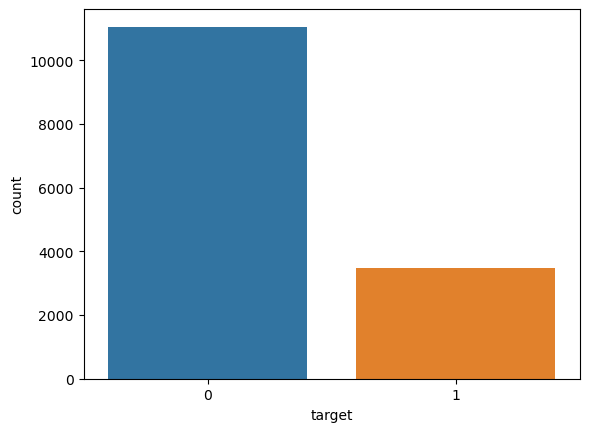

In [839]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(배당성향_df['target'])


In [909]:
배당성향_df[배당성향_df['target']==1]['회사명'].unique()

array(['(주)DB하이텍', '(주)MH에탄올', '(주)SH에너지화학', ..., '효성티앤씨(주)', '흥구석유(주)',
       '흥아해운(주)'], dtype=object)

In [910]:
배당성향_df[배당성향_df['target']==0]['회사명'].unique()

array(['(주)DB하이텍', '(주)MH에탄올', '(주)SH에너지화학', ..., '휴마시스(주)', '흥구석유(주)',
       '흥아해운(주)'], dtype=object)

c:\Users\msi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

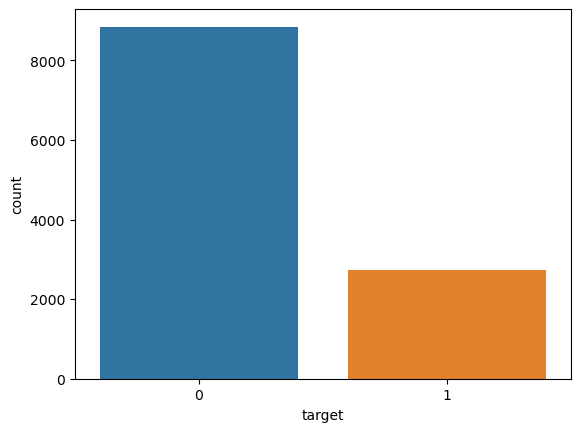

In [911]:
sns.countplot(배당성향_df[배당성향_df['회계년도']<=2019]['target'])

c:\Users\msi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

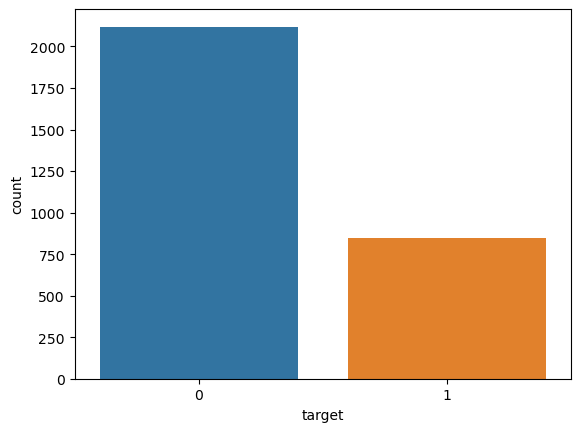

In [912]:
sns.countplot(배당성향_df[배당성향_df['회계년도']>=2020]['target'])

In [915]:
배당성향_df.isna().sum()

회사명          0
거래소코드        0
회계년도         0
당기순이익(손실)    0
배당금_현금       0
배당성향         0
조건1          0
배당성향_변동률     0
배당성향_std     0
조건2          0
조건3          0
target       0
dtype: int64

In [916]:
배당성향_df.drop(['당기순이익(손실)','배당금_현금','배당성향','조건1'	,'배당성향_변동률','배당성향_std','조건2','조건3'],axis=1,inplace=True)

In [917]:
배당성향_df.to_csv('target.csv',encoding='UTF-8-sig')

In [918]:
배당성향_df.target.value_counts()

0    10963
1     3584
Name: target, dtype: int64

In [919]:
배당성향_df

,회사명,거래소코드,회계년도,target
0,(주)DB하이텍,000990,2011,0
1,(주)DB하이텍,000990,2012,0
2,(주)DB하이텍,000990,2013,0
3,(주)DB하이텍,000990,2014,0
4,(주)DB하이텍,000990,2015,0
...,...,...,...,...
14542,흥아해운(주),003280,2016,1
14543,흥아해운(주),003280,2017,0
14544,흥아해운(주),003280,2018,0
14545,흥아해운(주),003280,2019,0
